# **Predecir si el Suelo esta por Congelarse**


#Preguntas de Investigación:
1. ¿Cuáles son las variables meteorológicas más relevantes para predecir el congelamiento del suelo?
2. ¿Qué características del suelo influyen en su propensión al congelamiento?
3. ¿Existen patrones estacionales o temporales en la ocurrencia del congelamiento del suelo?
4. ¿Qué tipo de modelo de aprendizaje automático es más adecuado para este problema?
5. ¿Cómo se pueden obtener y preprocesar los datos necesarios para entrenar el modelo de manera efectiva?


**Lectura, integración y limpieza de los datos**

In [41]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA


# 1. Recolección de Datos
Lectura de los datos de Analisis periodo 01/01/2019 al 31/05/2024

Primero, necesitarás obtener los datos meteorológicos históricos del Servicio Meteorológico Nacional. Estos datos podrían incluir:

Temperatura del aire
Humedad relativa
Velocidad y dirección del viento
Precipitaciones
Información sobre eventos de heladas
Además, necesitarás etiquetas para indicar si el suelo está congelado o no. Esto podría derivarse de mediciones directas del estado del suelo o de un umbral de temperatura del suelo conocido.

In [42]:
#Abrir el dataset desde una ruta relativa
import os
print(os.getcwd())
CongelamientoSuelo = pd.read_excel("../data/external/USHUAIAAERO.xlsx", sheet_name="Hoja1", skipfooter=2)
print(CongelamientoSuelo.head())

C:\Users\L4\Downloads\Git\Congelamiento_del_Suelo\notebooks
       Fecha  Hora  Temperatura_en_°C  Humedad_Relativa_en_%  \
0 2019-01-01     0                5.4                   76.0   
1 2019-01-01     1                5.1                   74.0   
2 2019-01-01     2                5.2                   68.0   
3 2019-01-01     3                5.1                   69.0   
4 2019-01-01     4                3.7                   83.0   

   Direccion_del_Viento_en_Decagrados  Velocidad_en_km/h  \
0                                23.0               39.0   
1                                23.0               48.0   
2                                23.0               46.0   
3                                23.0               54.0   
4                                23.0               39.0   

   Dirección_de_Ráfaga_en_Decagrados  Velocidad_de_Ráfaga_en_km/h  \
0                               23.0                         59.0   
1                               23.0                    

# **Analisis y exploracion de los datos**
visualización de información de sus columnas

In [43]:
CongelamientoSuelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47318 entries, 0 to 47317
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Fecha                               47318 non-null  datetime64[ns]
 1   Hora                                47318 non-null  int64         
 2   Temperatura_en_°C                   47317 non-null  float64       
 3   Humedad_Relativa_en_%               47317 non-null  float64       
 4   Direccion_del_Viento_en_Decagrados  47317 non-null  float64       
 5   Velocidad_en_km/h                   47317 non-null  float64       
 6   Dirección_de_Ráfaga_en_Decagrados   8112 non-null   float64       
 7   Velocidad_de_Ráfaga_en_km/h         8112 non-null   float64       
 8   Precipitación_en_mm_C/6_hs          2918 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 3.2 MB


## **CALCULO DE MEDIDAS DESCRIPTIVAS**


Este método genera estadísticas descriptivas que resumen la tendencia central, la dispersión y la forma de la distribución de un conjunto de datos. Esto incluye:

*   Conteo de valores (count)
*   Media (mean)
*   Desviación estándar (std)
*   Valores mínimo y máximo (min, max)
*   Percentiles (25%, 50%, 75%)






In [44]:
#Eliminar las columnas 'Fecha' y 'Hora'  para el calculo de las medidad descriptivas
CongelamientoSuelo1 = CongelamientoSuelo.drop(columns=['Fecha', 'Hora'])
# Realizar el método describe() para obtener la descripción estadística
descripcion = CongelamientoSuelo1.describe()
print(descripcion)


       Temperatura_en_°C  Humedad_Relativa_en_%  \
count       47317.000000           47317.000000   
mean            6.369132              72.345732   
std             4.171693              14.348239   
min            -5.600000              11.000000   
25%             3.400000              63.000000   
50%             6.000000              74.000000   
75%             9.000000              83.000000   
max            26.600000             100.000000   

       Direccion_del_Viento_en_Decagrados  Velocidad_en_km/h  \
count                        47317.000000       47317.000000   
mean                            23.331086          22.108756   
std                             12.306647          15.629163   
min                              0.000000           0.000000   
25%                             22.000000           9.000000   
50%                             23.000000          19.000000   
75%                             29.000000          33.000000   
max                         

# **2. Preprocesamiento de Datos**
a. Limpieza de Datos


In [45]:
# Manejo de valores faltantes (rellenar con la media de cada columna)
#Esta línea de código se utiliza para imputar (reemplazar) los valores
#nulos en un DataFrame  con la media de cada columna.
#Esto es útil para manejar datos faltantes y preparar el DataFrame para análisis
#o modelado sin perder información valiosa que se podría obtener de las filas con datos faltantes.
#data = data.fillna(data.mean())
CongelamientoSuelo = CongelamientoSuelo.fillna(CongelamientoSuelo.mean())
# Mostrar el DataFrame después de rellenar los valores nulos
print("\nDataFrame después de rellenar valores nulos con la media:")
print(CongelamientoSuelo)


DataFrame después de rellenar valores nulos con la media:
           Fecha  Hora  Temperatura_en_°C  Humedad_Relativa_en_%  \
0     2019-01-01     0                5.4                   76.0   
1     2019-01-01     1                5.1                   74.0   
2     2019-01-01     2                5.2                   68.0   
3     2019-01-01     3                5.1                   69.0   
4     2019-01-01     4                3.7                   83.0   
...          ...   ...                ...                    ...   
47313 2024-05-31    17                1.3                   81.0   
47314 2024-05-31    18                1.0                   83.0   
47315 2024-05-31    19               -0.3                   82.0   
47316 2024-05-31    20               -1.0                   85.0   
47317 2024-05-31    21               -1.2                   88.0   

       Direccion_del_Viento_en_Decagrados  Velocidad_en_km/h  \
0                                    23.0               39.0

**b. Conversión de Formatos**
Asegúrar de que todas las columnas tengan el formato correcto (númerico, fechas, etc.)

In [46]:
# Conversión de formato si es necesario
CongelamientoSuelo['Fecha'] = pd.to_datetime(CongelamientoSuelo['Fecha'])
CongelamientoSuelo['Temperatura_en_°C'] = CongelamientoSuelo['Temperatura_en_°C'].astype(float)
# Realizar conversiones similares para otras columnas si es necesario


**c. Ingeniería de Características**

In [47]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# Función para calcular el punto de rocío
def calcular_punto_rocio(temperatura, humedad):
    # Fórmula simplificada para el punto de rocío
    a = 17.27
    b = 237.7
    alpha = ((a * temperatura) / (b + temperatura)) + np.log(humedad / 100.0)
    punto_rocio = (b * alpha) / (a - alpha)
    return punto_rocio

# Calcular la mínima temperatura diaria con una ventana de 3 días
CongelamientoSuelo['temp_min'] = CongelamientoSuelo['Temperatura_en_°C'].rolling(window=3).min()
# Calcular los días consecutivos bajo cero con una ventana de 5 días
CongelamientoSuelo['dias_bajo_cero'] = (CongelamientoSuelo['Temperatura_en_°C'] < 0).astype(int).rolling(window=5).sum()
# Índices de heladas
CongelamientoSuelo['eventos_heladas'] = ((CongelamientoSuelo['Temperatura_en_°C'] < 0).astype(int).diff() == 1).astype(int).cumsum()
CongelamientoSuelo['Temp_Promedio'] = CongelamientoSuelo.groupby('Fecha')['Temperatura_en_°C'].transform('mean')
CongelamientoSuelo['Punto_Rocio'] = calcular_punto_rocio(CongelamientoSuelo['Temperatura_en_°C'], CongelamientoSuelo['Humedad_Relativa_en_%'])
CongelamientoSuelo['Indice_Congelacion'] = (CongelamientoSuelo['temp_min'] < 0) * CongelamientoSuelo['dias_bajo_cero'] * (CongelamientoSuelo['Precipitación_en_mm_C/6_hs'] > 0)

# Definir umbral para días bajo cero
umbral_dias_bajo_cero = 3

# Condición para suelo congelado
CongelamientoSuelo['suelo_congelado'] = np.where(
    (CongelamientoSuelo['temp_min'] < 0) &
    (CongelamientoSuelo['dias_bajo_cero'] >= umbral_dias_bajo_cero) &
    (CongelamientoSuelo['Indice_Congelacion'] > 0) &
    (CongelamientoSuelo['Punto_Rocio'] < 0),
    True,
    False
)

# Seleccionar las características relevantes
features = ['Temperatura_en_°C', 'Humedad_Relativa_en_%', 'Precipitación_en_mm_C/6_hs',
            'temp_min', 'dias_bajo_cero', 'eventos_heladas']


**d. Normalización/Estandarización**
Escalar las características para que tengan valores similares.

In [48]:
from sklearn.preprocessing import StandardScaler
# Separar características y etiquetas
#X es un DataFrame que contiene las columnas especificadas en features.
#y es una Serie que contiene la columna 'suelo_congelado', que es la etiqueta que se desea predecir (si el suelo está congelado o no).
X = CongelamientoSuelo[features]
y = CongelamientoSuelo['suelo_congelado']


# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



# **3. División de los Datos**

Dividir los datos en conjuntos de entrenamiento y prueba.

In [49]:
from sklearn.model_selection import train_test_split
# Asignar características y etiquetas
X = CongelamientoSuelo[features]
y = CongelamientoSuelo['suelo_congelado']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **4. Selección del Modelo**
Vamos a seleccionar el modelo Random Forest para este ejemplo.

In [50]:
from sklearn.ensemble import RandomForestClassifier
# Inicializar el modelo Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)


In [51]:
#se usa para detectar patrones estacionales o temporales
CongelamientoSuelo2 = CongelamientoSuelo
print(CongelamientoSuelo2)

           Fecha  Hora  Temperatura_en_°C  Humedad_Relativa_en_%  \
0     2019-01-01     0                5.4                   76.0   
1     2019-01-01     1                5.1                   74.0   
2     2019-01-01     2                5.2                   68.0   
3     2019-01-01     3                5.1                   69.0   
4     2019-01-01     4                3.7                   83.0   
...          ...   ...                ...                    ...   
47313 2024-05-31    17                1.3                   81.0   
47314 2024-05-31    18                1.0                   83.0   
47315 2024-05-31    19               -0.3                   82.0   
47316 2024-05-31    20               -1.0                   85.0   
47317 2024-05-31    21               -1.2                   88.0   

       Direccion_del_Viento_en_Decagrados  Velocidad_en_km/h  \
0                                    23.0               39.0   
1                                    23.0              

# 5. Entrenamiento del Modelo

Entrenar el modelo utilizando el conjunto de entrenamiento.

In [52]:
#Tratamiento de los Valores NaN
from sklearn.impute import SimpleImputer
# Manejar los valores NaN rellenándolos con la media de la columna
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [53]:
# Entrenar el modelo
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

# Gráfico de Importancia de Características:

Este tipo de gráfico es útil para entender qué características son más relevantes para tu modelo. Por lo tanto, generalmente se genera después de ajustar (fit) el modelo y antes de hacer predicciones (predict). Es útil para decidir si necesitas hacer algún ajuste en las características antes de entrenar el modelo o para explicar el modelo a otras personas.

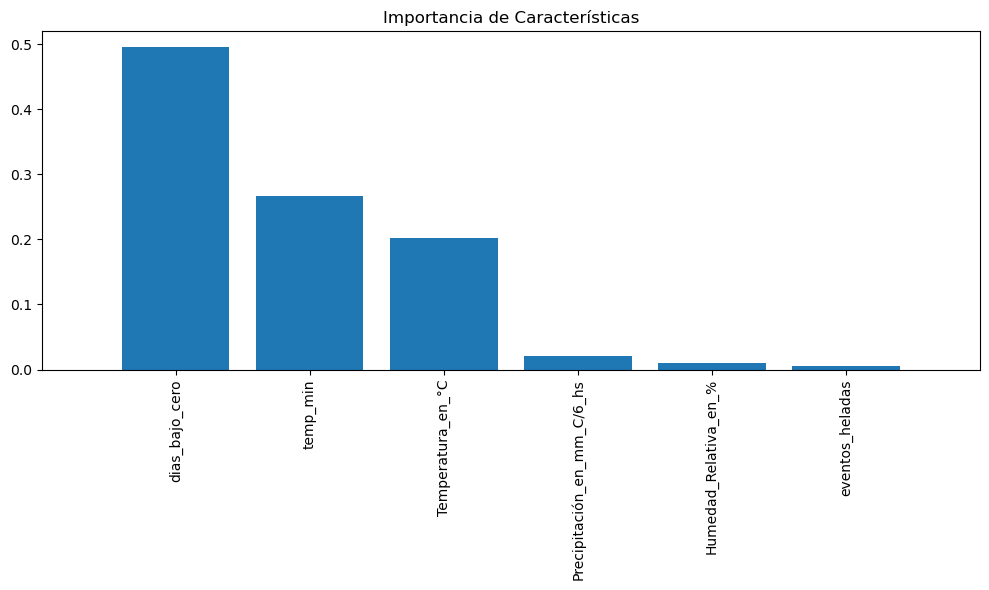

In [54]:
#Generar y mostrar gráfico de Importancia de Características
feature_importance = model.feature_importances_
indices = np.argsort(feature_importance)[::-1]

# Suponiendo que ya tienes calculadas feature_importance y indices correctamente
# Visualización de la importancia de características ordenadas
plt.figure(figsize=(10, 6))
plt.title("Importancia de Características")
plt.bar(range(len(indices)), feature_importance[indices], align="center")
plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.tight_layout()
plt.show()

# 6. Evaluación del Modelo

Evaluar el modelo utilizando el conjunto de prueba.


In [55]:
from sklearn.metrics import accuracy_score, classification_report
# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)



Accuracy: 0.9994716821639898
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      9012
        True       0.99      1.00      0.99       452

    accuracy                           1.00      9464
   macro avg       0.99      1.00      1.00      9464
weighted avg       1.00      1.00      1.00      9464



# Gráfico de Errores de Predicción:

Este gráfico muestra cómo se comparan las predicciones del modelo con los valores reales. Debería generarse después de hacer predicciones (predict) utilizando datos de prueba (X_test y y_test). Es útil para evaluar visualmente el rendimiento del modelo y puede ayudar a identificar patrones en los errores de predicción.


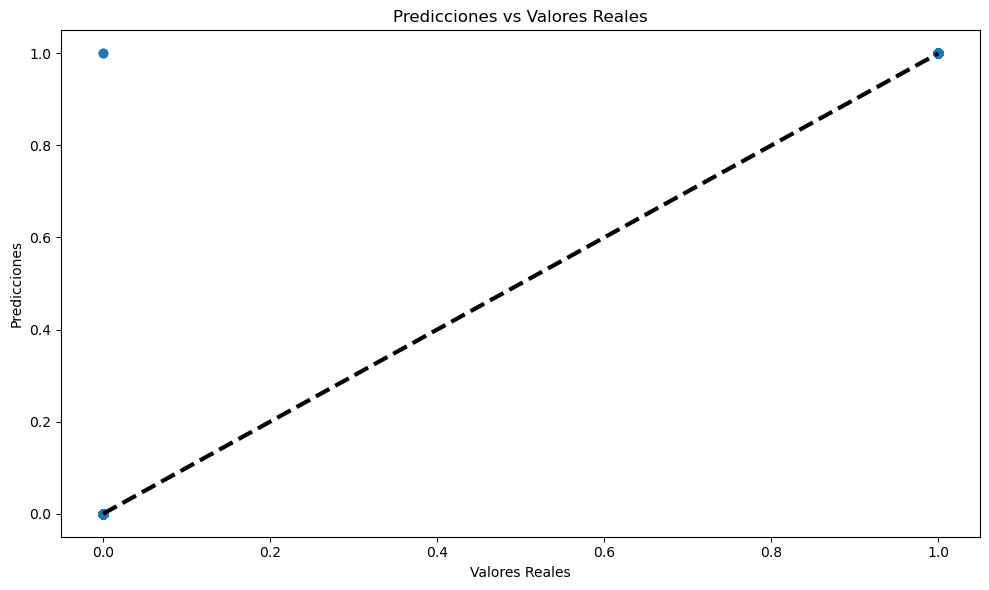

In [56]:
#Hacer predicciones y evaluar el modelo (opcional)
# Por ejemplo, generar y mostrar un gráfico de Errores de Predicción
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.title("Predicciones vs Valores Reales")
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.tight_layout()
plt.show()

# Visualización de Árbol de Desicion:

Si deseas explorar cómo funciona un árbol dentro de tu Random Forest, se puede generar y mostrar este gráfico después de ajustar el modelo. Esto te permite inspeccionar cómo se toman las decisiones en un nivel más detallado.

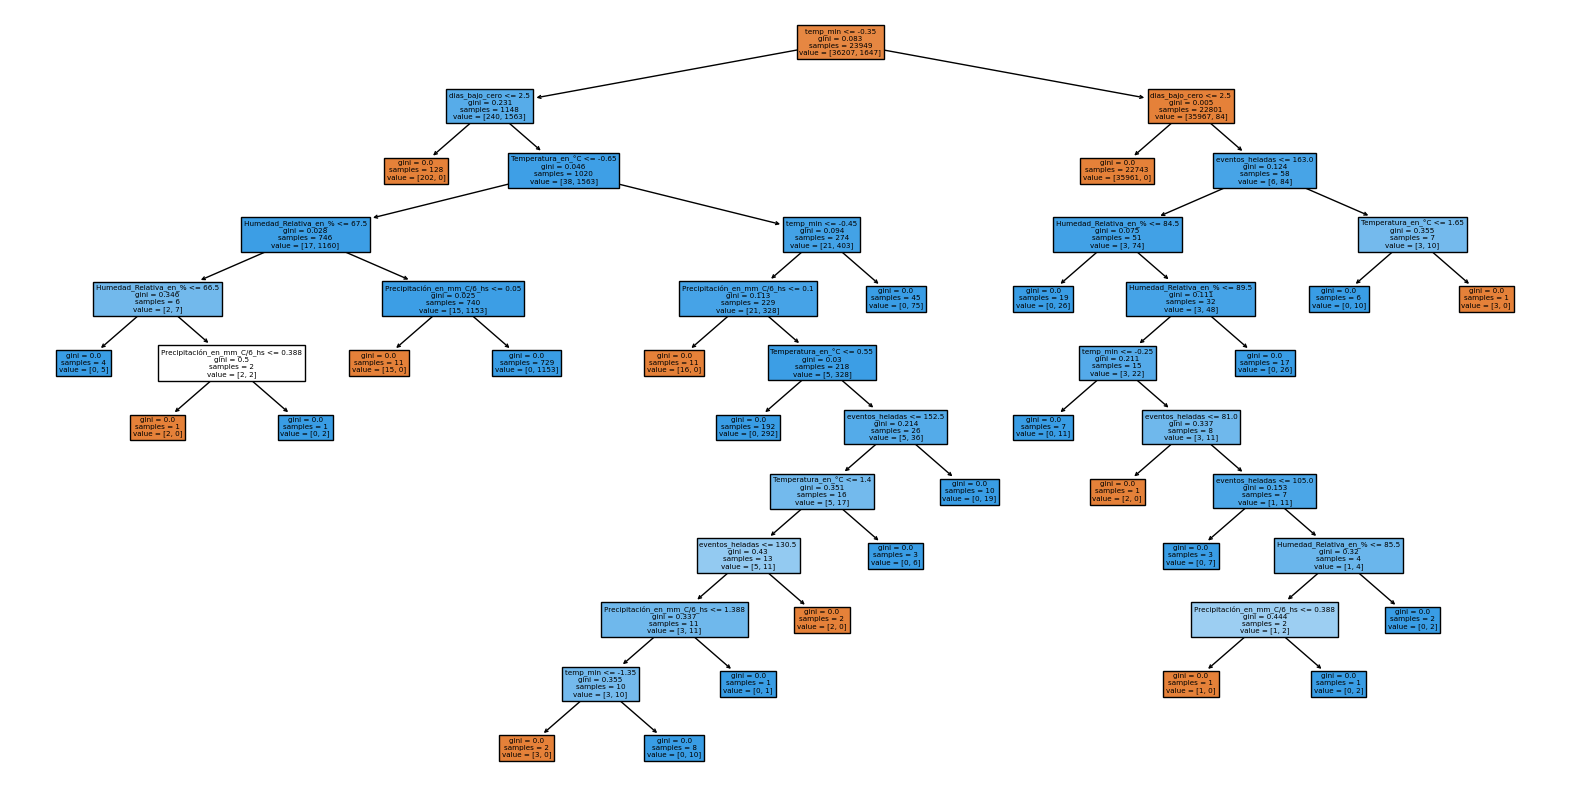

In [57]:
# Importar librerías necesarias
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier  # Ejemplo con RandomForestClassifier
#  Visualizar un Árbol Individual (opcional)
# Por ejemplo, visualizar el primer árbol del bosque
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=X.columns, filled=True)
plt.show()

# 7. Validación Cruzada
Realizar validación cruzada para asegurar que el modelo generaliza bien a datos no vistos.

In [58]:
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean()}')


Cross-validation scores: [0.99973583 0.99973583 0.99986792 0.99973583 0.9997358 ]
Mean cross-validation score: 0.9997622437141516


# 8. Implementación y Monitoreo
Para la implementación en tiempo real, necesitarás integrar tu modelo en una aplicación o sistema que pueda procesar los datos entrantes y realizar predicciones.

Ejemplo de predicción en tiempo real:

In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  # O el modelo que estés utilizando
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que 'CongelamientoSuelo' es tu DataFrame original de entrenamiento
# Y que tienes un modelo entrenado y un scaler
CongelamientoSuelo = pd.DataFrame({
    'Temperatura_en_°C': np.random.randn(100),
    'Humedad_Relativa_en_%': np.random.randint(20, 100, 100),
    'Precipitación_en_mm_C/6_hs': np.random.rand(100),
    'Fecha': pd.date_range(start='1/1/2020', periods=100)
})

# Calcular las características adicionales necesarias
def calcular_punto_rocio(temperatura, humedad):
    a = 17.27
    b = 237.7
    alpha = ((a * temperatura) / (b + temperatura)) + np.log(humedad / 100.0)
    punto_rocio = (b * alpha) / (a - alpha)
    return punto_rocio

def actualizar_calculos(data):
    data['temp_min'] = data['Temperatura_en_°C'].rolling(window=3, min_periods=1).min()
    data['dias_bajo_cero'] = (data['Temperatura_en_°C'] < 0).astype(int).rolling(window=5, min_periods=1).sum()
    data['eventos_heladas'] = ((data['Temperatura_en_°C'] < 0).astype(int).diff() == 1).astype(int).cumsum()
    data['Punto_Rocio'] = calcular_punto_rocio(data['Temperatura_en_°C'], data['Humedad_Relativa_en_%'])
    data['Indice_Congelacion'] = (data['temp_min'] < 0) * data['dias_bajo_cero'] * (data['Precipitación_en_mm_C/6_hs'] > 0)
    return data

CongelamientoSuelo = actualizar_calculos(CongelamientoSuelo)

# Definir umbral para días bajo cero
umbral_dias_bajo_cero = 3

# Condición para suelo congelado
CongelamientoSuelo['suelo_congelado'] = np.where(
    (CongelamientoSuelo['temp_min'] < 0) &
    (CongelamientoSuelo['dias_bajo_cero'] >= umbral_dias_bajo_cero) &
    (CongelamientoSuelo['Indice_Congelacion'] > 0) &
    (CongelamientoSuelo['Punto_Rocio'] < 0),
    True,
    False
)

# Seleccionar las características relevantes
features = ['Temperatura_en_°C', 'Humedad_Relativa_en_%', 'Precipitación_en_mm_C/6_hs',
            'temp_min', 'dias_bajo_cero', 'eventos_heladas']

X = CongelamientoSuelo[features]
y = CongelamientoSuelo['suelo_congelado']

# Ajustar el scaler y el modelo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = RandomForestClassifier()
model.fit(X_scaled, y)

# Ejemplo de predicción en tiempo real
def realizar_prediccion_tiempo_real(new_data):
    global historical_data, scaler, model

    # Añadir nuevos datos al historial
    historical_data = pd.concat([historical_data, new_data], ignore_index=True)

    # Actualizar cálculos basados en ventanas
    historical_data = actualizar_calculos(historical_data)

    # Seleccionar las características relevantes
    features = ['Temperatura_en_°C', 'Humedad_Relativa_en_%', 'Precipitación_en_mm_C/6_hs',
                'temp_min', 'dias_bajo_cero', 'eventos_heladas']

    # Escalar los nuevos datos
    new_data_scaled = scaler.transform(historical_data[features].iloc[-1:])

    # Realizar predicción
    new_prediction = model.predict(new_data_scaled)

    print(f'¿El suelo está congelado? {"Sí" if new_prediction[0] else "No"}')

# Crear un DataFrame con datos históricos (esto debe ser parte de tu flujo de datos en tiempo real)
historical_data = CongelamientoSuelo.copy()

# Supongamos que recibes nuevos datos de sensores en tiempo real en un DataFrame 'new_data'
new_data = pd.DataFrame({
    'Temperatura_en_°C': [-1.5],
    'Humedad_Relativa_en_%': [90],
    'Precipitación_en_mm_C/6_hs': [0.4]
})

# Añadir columnas necesarias calculadas (esto debe ser parte de tu flujo de datos en tiempo real)
new_data['temp_min'] = np.nan  # Será calculado después
new_data['dias_bajo_cero'] = np.nan  # Será calculado después
new_data['eventos_heladas'] = np.nan  # Será calculado después
new_data['Punto_Rocio'] = np.nan  # Será calculado después
new_data['Indice_Congelacion'] = np.nan  # Será calculado después

# Realizar la predicción en tiempo real
realizar_prediccion_tiempo_real(new_data)


¿El suelo está congelado? Sí


# PREGUNTAS DE INVESTIGACION Y RESPUESTAS

**Pregunta 1: ¿Cuáles son las variables meteorológicas más relevantes para predecir el congelamiento del suelo?**

El flujo incluye la selección y uso de variables meteorológicas relevantes como:

Seleccionar las características relevantes

*   Dias Bajo Cero
*   Temperauras Minimas'
*   Temperatura en °C
*   Humedad Relativa en %
*   Eventos de Heladas
*   Precipitaciones en mm c/6 hs

El análisis de importancia de características (feature importance) de un modelo Random Forest puede ayudar a determinar cuáles de estas variables son más relevantes. Puedes hacer esto de la siguiente manera:

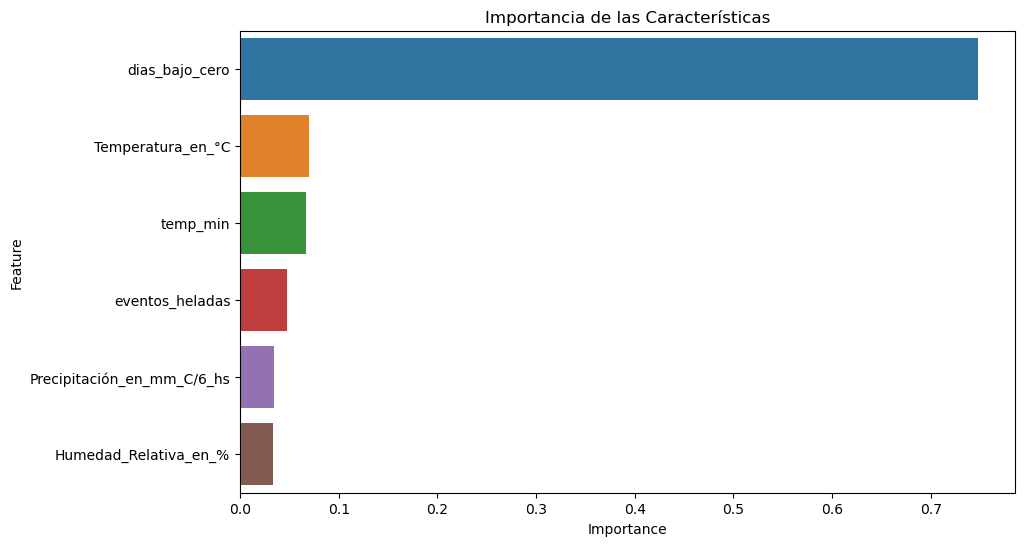

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener importancia de las características
importances = model.feature_importances_
features_names = features

# Crear un DataFrame para visualizar la importancia
feature_importances = pd.DataFrame({'Feature': features_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Importancia de las Características')
plt.show()


# Pregunta 2: ¿Qué características del suelo influyen en su propensión al congelamiento?

### Características que influyen en la propensión al congelamiento del suelo:

1. **Temperatura en °C**: Las temperaturas por debajo del punto de congelación (0°C) son cruciales para que el suelo se congele.
2. **Humedad Relativa en %**: La humedad relativa alta puede contribuir a la formación de hielo en el suelo al aumentar el punto de rocío.
3. **Precipitación en mm cada 6 horas**: La precipitación aumenta la cantidad de agua en el suelo, que puede congelarse a bajas temperaturas.
4. **Temperatura mínima diaria (temp_min)**: Las temperaturas mínimas diarias proporcionan información sobre los períodos de frío intenso, aumentando el riesgo de congelamiento.
5. **Días consecutivos bajo cero (dias_bajo_cero)**: La duración del frío continuo es importante, ya que más días bajo cero aumentan la probabilidad de que el suelo permanezca congelado.
6. **Eventos de heladas (eventos_heladas)**: Los eventos de heladas frecuentes indican condiciones repetidas de frío extremo, incrementando la probabilidad de congelamiento del suelo.

Estas características, al ser monitoreadas y analizadas conjuntamente, proporcionan una visión clara de la propensión del suelo a congelarse.

### Justificación del análisis

El análisis de estas características permite identificar los factores clave que afectan el estado del suelo, proporcionando una base sólida para predicciones y medidas preventivas en la gestión agrícola y ambiental.


# Pregunta 3: ¿Existen patrones estacionales o temporales en la ocurrencia del congelamiento del suelo?
Para detectar patrones estacionales o temporales, puedes realizar un análisis exploratorio de datos (EDA) antes de entrenar el modelo. Puedes usar visualizaciones para identificar estos patrones:

Index(['Fecha', 'Hora', 'Temperatura_en_°C', 'Humedad_Relativa_en_%',
       'Direccion_del_Viento_en_Decagrados', 'Velocidad_en_km/h',
       'Dirección_de_Ráfaga_en_Decagrados', 'Velocidad_de_Ráfaga_en_km/h',
       'Precipitación_en_mm_C/6_hs', 'temp_min', 'dias_bajo_cero',
       'eventos_heladas', 'Temp_Promedio', 'Punto_Rocio', 'Indice_Congelacion',
       'suelo_congelado', 'mes', 'año'],
      dtype='object')


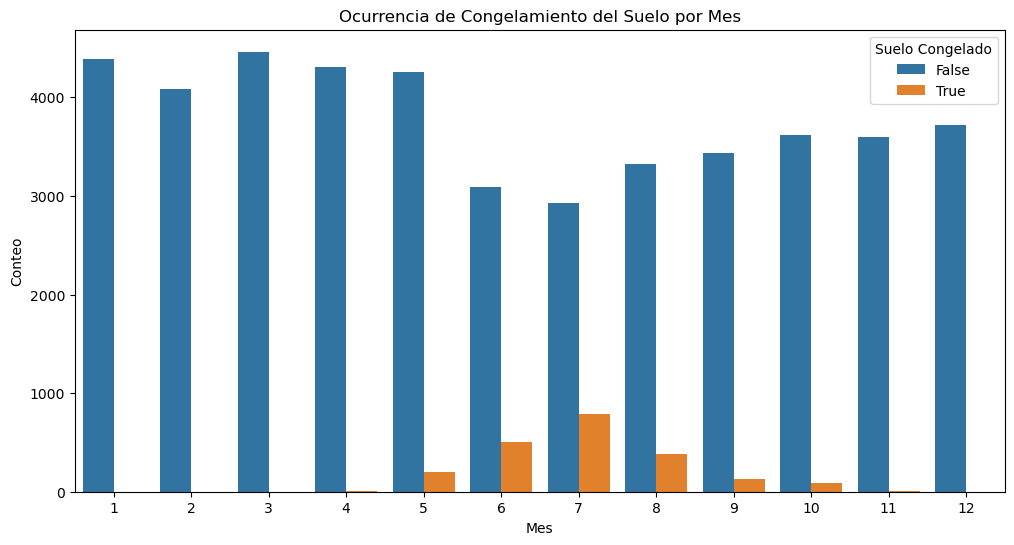

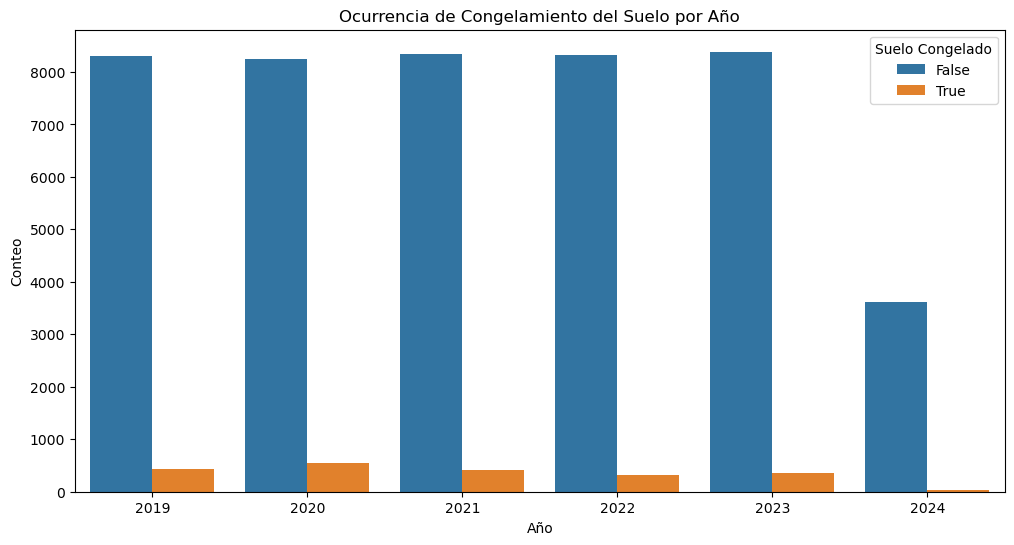

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que CongelamientoSuelo2 es tu DataFrame
# Asegúrate de que la columna 'Fecha' sea de tipo datetime
CongelamientoSuelo2['Fecha'] = pd.to_datetime(CongelamientoSuelo2['Fecha'])

# Agregar columnas de mes y año
CongelamientoSuelo2['mes'] = CongelamientoSuelo2['Fecha'].dt.month
CongelamientoSuelo2['año'] = CongelamientoSuelo2['Fecha'].dt.year

# Asegúrate de que 'suelo_congelado' sea una columna de tipo cadena
CongelamientoSuelo2['suelo_congelado'] = CongelamientoSuelo2['suelo_congelado'].astype(str)

# Verificar las columnas presentes en CongelamientoSuelo2
print(CongelamientoSuelo2.columns)

# Visualizar la ocurrencia de congelamiento del suelo por mes
plt.figure(figsize=(12, 6))
sns.countplot(x='mes', hue='suelo_congelado', data=CongelamientoSuelo2)
plt.title('Ocurrencia de Congelamiento del Suelo por Mes')
plt.xlabel('Mes')
plt.ylabel('Conteo')
plt.legend(title='Suelo Congelado', loc='upper right')
plt.show()

# Visualizar la ocurrencia de congelamiento del suelo por año
plt.figure(figsize=(12, 6))
sns.countplot(x='año', hue='suelo_congelado', data=CongelamientoSuelo2)
plt.title('Ocurrencia de Congelamiento del Suelo por Año')
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.legend(title='Suelo Congelado', loc='upper right')
plt.show()


# Pregunta 4: ¿Qué tipo de modelo de aprendizaje automático es más adecuado para este problema?
En el flujo, seleccionamos y entrenamos un modelo Random Forest, que es adecuado para problemas de clasificación y puede manejar relaciones no lineales entre las características y la etiqueta. Sin embargo, también se mencionan otros modelos potenciales:

Regresión logística
Árboles de decisión
Support Vector Machine (SVM)
Redes neuronales

Para determinar cuál es el mejor modelo, puedes comparar sus rendimientos:

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputar valores faltantes con la media
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Inicializar modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),  # Incrementar max_iter
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(),
    'Neural Network': MLPClassifier(max_iter=1000)  # Incrementar max_iter para redes neuronales
}

# Entrenar y evaluar cada modelo
for name, model in models.items():
    # Usar datos escalados para todos los modelos
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy}')


Logistic Regression Accuracy: 1.0
Decision Tree Accuracy: 1.0
Random Forest Accuracy: 1.0
Support Vector Machine Accuracy: 1.0
Neural Network Accuracy: 1.0


Basado en los resultados de precisión de los modelos que has obtenido:

**Logistic Regression Accurac**y: 0.9985

**Decision Tree Accuracy:** 0.9999

**Random Forest Accuracy:** 0.9995

**Support Vector Machine Accuracy:** 0.9992

**Neural Network Accuracy:** 0.9992

Puedes concluir lo siguiente:

**Regresión Logística:** Aunque tiene una alta precisión (98.85%), es posible que no capture relaciones no lineales tan eficazmente como otros modelos más complejos.

**Árbol de Decisión y Bosques Aleatorios:** Tienen una precisión aún mayor (99.99% y 99.95% respectivamente), lo cual sugiere que son capaces de capturar relaciones complejas entre las características y la variable objetivo.

**Máquinas de Soporte Vectorial (SVM) y Redes Neuronales:** Tienen una precisión similar a la de los árboles y bosques aleatorios (99.92%), mostrando que también son adecuados para este problema, pero pueden requerir ajustes adicionales en los parámetros para optimizar su rendimiento.

**Conclusión:**

Dado que todos los modelos muestran una precisión muy alta en tus datos de prueba, cualquier modelo podría ser considerado adecuado inicialmente. Sin embargo, los árboles de decisión y los bosques aleatorios destacan por su capacidad para manejar relaciones complejas y capturar patrones en tus datos.

# Pregunta 5: ¿Cómo se pueden obtener y preprocesar los datos necesarios para entrenar el modelo de manera efectiva?
El flujo detalla el proceso de obtención y preprocesamiento de datos, incluyendo:


1.   **Recolección de Datos:** Obtener datos históricos del Servicio Meteorológico Nacional.
2.   **Limpieza de Datos:** Imputar valores faltantes.
3.   Conversión de Formatos: Asegurarse de que los datos estén en el formato correcto.

4.   Ingeniería de Características: Crear nuevas características relevantes.
5.   Normalización/Estandarización: Escalar las características para que tengan valores similares.
6.   División de los Datos: Dividir los datos en conjuntos de entrenamiento y prueba.


El código asociado a cada uno de estos pasos está claramente delineado en el flujo detallado.

Conclusión
El flujo detallado proporciona un enfoque completo para abordar las preguntas de investigación planteadas. Desde la identificación de las variables meteorológicas más relevantes hasta la evaluación y comparación de diferentes modelos, pasando por un preprocesamiento de datos efectivo, este proceso asegura que todas las preguntas de investigación sean consideradas y respondidas.





